## JUPITER

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import SkyCoord
from collections import defaultdict
import datetime
from utils import *
from astropy.io import ascii

In [46]:
import importlib
plots = importlib.import_module('plots')
importlib.reload(plots)
from plots import *

import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

Total stack (over every ScW)

In [50]:
s_flu, s_var, s_expo, s_flux, s_var_flux, body_i, body_j = stack_images(dir="../data/Jupiter/3-15keV/Images", table_dir='../data/jupiter_table.dat', crab_dir="../data/weighted_crab_averages.txt")

Failed to open 026700060010.001mosaic.fits: list index out of range
Failed to open 026700070010.001mosaic.fits: list index out of range
Failed to open 026700080010.001mosaic.fits: list index out of range
Failed to open 026700090010.001mosaic.fits: list index out of range
Failed to open 026700100010.001mosaic.fits: list index out of range
Failed to open 026700140010.001mosaic.fits: list index out of range
Failed to open 026700150010.001mosaic.fits: list index out of range
Failed to open 026700370010.001mosaic.fits: list index out of range
Failed to open 026700380010.001mosaic.fits: list index out of range
Failed to open 026700390010.001mosaic.fits: list index out of range
Failed to open 026700400010.001mosaic.fits: list index out of range
Failed to open 026800180010.001mosaic.fits: list index out of range
Failed to open 026800190010.001mosaic.fits: list index out of range
Failed to open 026800200010.001mosaic.fits: list index out of range
Failed to open 026800210010.001mosaic.fits: list

Plotting

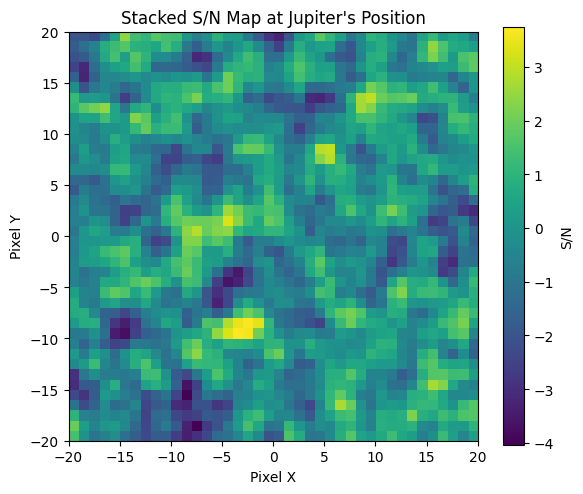

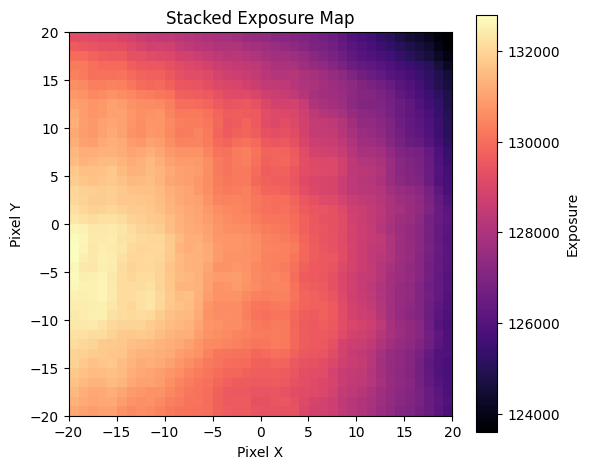

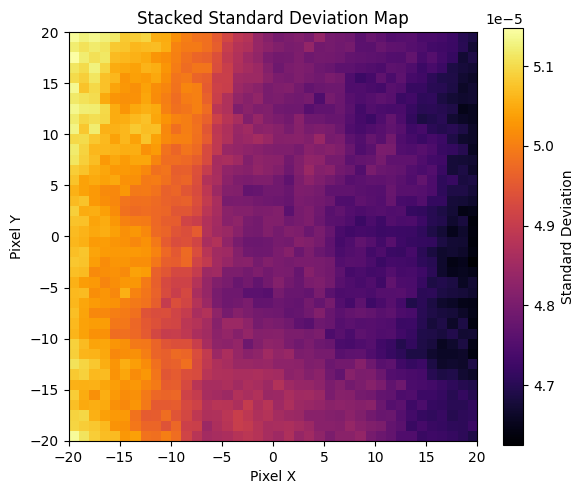

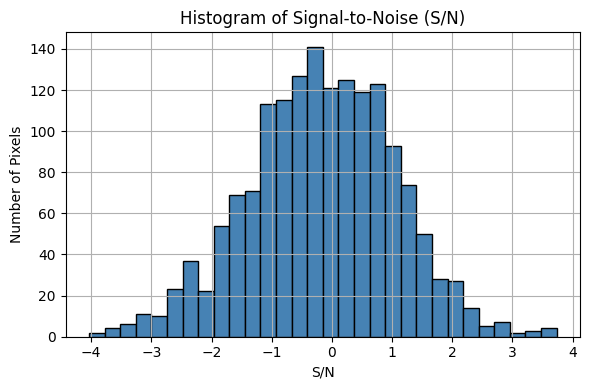

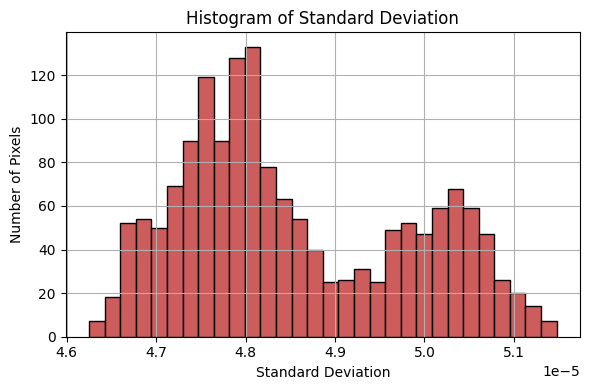

In [51]:
plot_span = 20
extent = [-plot_span, plot_span, -plot_span, plot_span]

# 93.6  arcsec/pixel for JEM-X

# Signal-to-noise (S/N) map
plt.figure(figsize=(6, 5))
plt.imshow(s_flu / np.sqrt(s_var), origin='lower', cmap='viridis', extent=extent)
plt.title("Stacked S/N Map at Jupiter's Position")
#plt.scatter(0, 0, c='r', marker='o', s=200, alpha=0.5, label="Jupiter Position")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
cbar = plt.colorbar()
cbar.set_label("S/N")
plt.tight_layout()

# Effective exposure map (normalized)
plt.figure(figsize=(6, 5))
plt.imshow(s_expo , origin='lower', cmap='magma', extent=extent) # / total_max_isgri_exp
plt.title("Stacked Exposure Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Exposure")
plt.tight_layout()

# Square root of the variance map
plt.figure(figsize=(6, 5))
plt.imshow(np.sqrt(s_var), origin='lower', cmap='inferno', extent=extent)
plt.title("Stacked Standard Deviation Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Standard Deviation")
plt.tight_layout()

# Histogram of S/N
plt.figure(figsize=(6, 4))
plt.hist((s_flu / np.sqrt(s_var)).flatten(), bins=30, color='steelblue', edgecolor='black')
plt.title("Histogram of Signal-to-Noise (S/N)")
plt.xlabel("S/N")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()

# Histogram of √variance
plt.figure(figsize=(6, 4))
plt.hist(np.sqrt(s_var).flatten(), bins=30, color='indianred', edgecolor='black')
plt.title("Histogram of Standard Deviation")
plt.xlabel("Standard Deviation")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()

Flux at center: -9.176e-04 ± 1.021e-03 ph/cm²/s
3sigma upper limit at center: 2.145e-03 ph/cm²/s

S/N at the center of the stacked map: -0.58
Probability of observing S/N ≥ -0.58: 68.37%


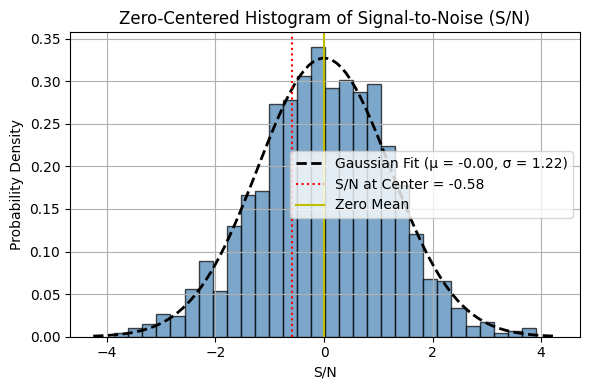

In [52]:
from scipy.stats import norm

# Compute S/N values and normalize by subtracting the empirical mean
s_n_values_raw = (s_flu / np.sqrt(s_var)).flatten()
empirical_mean = np.mean(s_n_values_raw)
s_n_values = s_n_values_raw - empirical_mean  # center at 0

# Histogram of S/N
hist, bin_edges = np.histogram(s_n_values, bins=30, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Fit a Gaussian to the centered data
mu, std = norm.fit(s_n_values)

# Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(s_n_values, bins=30, color='steelblue', edgecolor='black', density=True, alpha=0.7)
plt.title("Zero-Centered Histogram of Signal-to-Noise (S/N)")
plt.xlabel("S/N")
plt.ylabel("Probability Density")

# Plot Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k--', linewidth=2, label=f"Gaussian Fit (μ = {mu:.2f}, σ = {std:.2f})")

# Compute and center the S/N at the map center
body_i = np.clip(body_i, plot_span, s_flu.shape[0] - plot_span - 1)
body_j = np.clip(body_j, plot_span, s_flu.shape[1] - plot_span - 1)

center_sn_raw = s_flu[body_i, body_j] / np.sqrt(s_var[body_i, body_j])
center_sn = center_sn_raw - empirical_mean

center_flux = s_flux[body_i, body_j]
center_flux_err = np.sqrt(s_var_flux[body_i, body_j])

print(f"Flux at center: {center_flux:.3e} ± {center_flux_err:.3e} ph/cm²/s")
print(f"3sigma upper limit at center: {center_flux + 3 * center_flux_err:.3e} ph/cm²/s")

plt.axvline(center_sn, color='r', linestyle=':', label=f"S/N at Center = {center_sn:.2f}")
plt.axvline(0, color='y', linestyle='-', label="Zero Mean")

plt.legend()
plt.grid(True)
plt.tight_layout()

# Compute significance
probability = norm.cdf(center_sn, mu, std)
print()
print(f"S/N at the center of the stacked map: {center_sn:.2f}")
print(f"Probability of observing S/N ≥ {center_sn + mu:.2f}: {(1 - probability)*100:.2f}%")


## CRAB

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import SkyCoord
from collections import defaultdict
import datetime
from utils import *
from astropy.io import ascii
from scipy.ndimage import shift


In [40]:
import importlib
plots = importlib.import_module('plots')
importlib.reload(plots)
from plots import *

import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

In [37]:
crab_coords = SkyCoord.from_name("Crab")
crab_ra = crab_coords.ra.deg
crab_dec = crab_coords.dec.deg
print(f"Crab coordinates: RA = {crab_ra}, Dec = {crab_dec}")

Crab coordinates: RA = 83.6324, Dec = 22.0174


In [ ]:
s_flu, s_var, s_expo = stack_crab(dir="../data/Crab/15-30keV/Images")

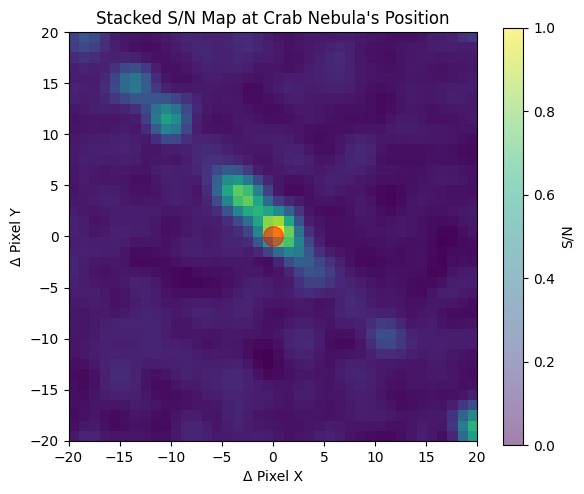

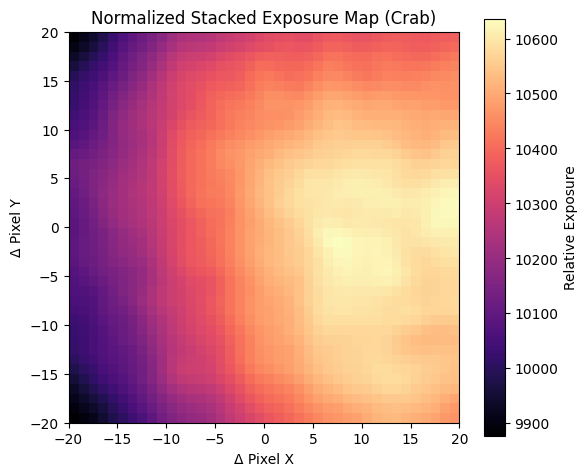

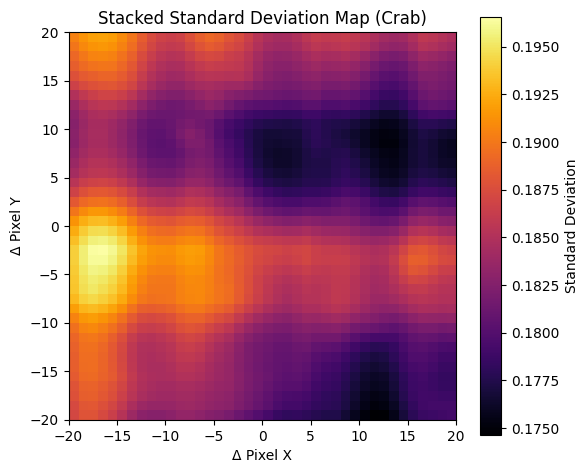

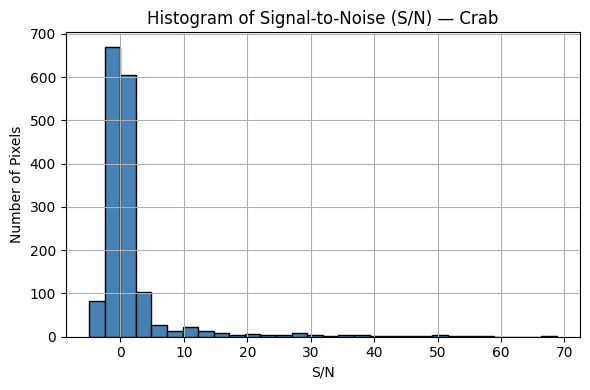

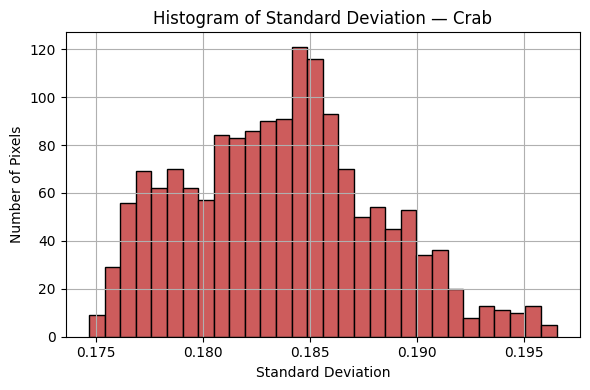

In [43]:
plot_span = 20
extent = [-plot_span, plot_span, -plot_span, plot_span]

# Signal-to-noise (S/N) map
plt.figure(figsize=(6, 5))
plt.imshow(s_flu / np.sqrt(s_var), origin='lower', cmap='viridis', extent=extent)
plt.scatter(0, 0, c='r', marker='o', s=200, alpha=0.5, label="Crab Position")
plt.title("Stacked S/N Map at Crab Nebula's Position")
plt.xlabel("Δ Pixel X")
plt.ylabel("Δ Pixel Y")
cbar = plt.colorbar()
cbar.set_label("S/N")
plt.tight_layout()

# Effective exposure map 
plt.figure(figsize=(6, 5))
plt.imshow(s_expo, origin='lower', cmap='magma', extent=extent)
plt.title("Normalized Stacked Exposure Map (Crab)")
plt.xlabel("Δ Pixel X")
plt.ylabel("Δ Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Relative Exposure")
plt.tight_layout()

# Square root of the variance map
plt.figure(figsize=(6, 5))
plt.imshow(np.sqrt(s_var), origin='lower', cmap='inferno', extent=extent)
plt.title("Stacked Standard Deviation Map (Crab)")
plt.xlabel("Δ Pixel X")
plt.ylabel("Δ Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Standard Deviation")
plt.tight_layout()

# Histogram of S/N
plt.figure(figsize=(6, 4))
plt.hist((s_flu / np.sqrt(s_var)).flatten(), bins=30, color='steelblue', edgecolor='black')
plt.title("Histogram of Signal-to-Noise (S/N) — Crab")
plt.xlabel("S/N")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()

# Histogram of √variance
plt.figure(figsize=(6, 4))
plt.hist(np.sqrt(s_var).flatten(), bins=30, color='indianred', edgecolor='black')
plt.title("Histogram of Standard Deviation — Crab")
plt.xlabel("Standard Deviation")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()


S/N at the center of the stacked map: 34.94
Probability of observing S/N >= 34.94: 0.00%


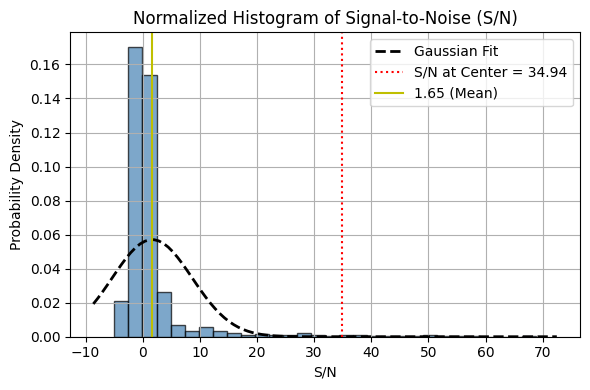

In [44]:
from scipy.stats import norm

# Normalize S/N histogram 
s_n_values = (s_flu / np.sqrt(s_var)).flatten() 
hist, bin_edges = np.histogram(s_n_values, bins=30, density=True) 

bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

mu, std = norm.fit(s_n_values)

# Plot the normalized S/N histogram
plt.figure(figsize=(6, 4))
plt.hist(s_n_values, bins=30, color='steelblue', edgecolor='black', density=True, alpha=0.7)
plt.title("Normalized Histogram of Signal-to-Noise (S/N)")
plt.xlabel("S/N")
plt.ylabel("Probability Density")

# Plot the Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k--', linewidth=2, label="Gaussian Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()

body_i = np.clip(body_i, plot_span, s_flu.shape[0] - plot_span - 1)
body_j = np.clip(body_j, plot_span, s_flu.shape[1] - plot_span - 1)

center_sn = s_flu[body_i, body_j] / np.sqrt(s_var[body_i, body_j])
#center_sn = s_flu[0, 0] / np.sqrt(s_var[0, 0])
print(f"S/N at the center of the stacked map: {center_sn:.2f}")

plt.axvline(center_sn, color='r', linestyle=':', label=f"S/N at Center = {center_sn:.2f}")
plt.axvline(mu, color='y', linestyle='-', label=f"{mu:.2f} (Mean)")

plt.legend()
plt.tight_layout()

probability = norm.cdf(center_sn, mu, std)
print(f"Probability of observing S/N >= {center_sn:.2f}: {(1 - probability)*100:.2f}%")